In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraModel, ElectraTokenizer, get_linear_schedule_with_warmup
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             multilabel_confusion_matrix, hamming_loss,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm 
import numpy as np
import ast 

2025-05-24 09:34:23.530448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748079263.730190      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748079263.789069      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/zalupinsk/2024_y.csv')
df = df[['text', 'multi_labels','hier_label']]

def list_func(df):
    # Преобразуем строки меток в списки (если они ещё не списки)
    df['multi_labels'] = df['multi_labels'].apply(eval) 
    return df

df = list_func(df)

MODEL_NAME = "ai-forever/ruElectra-medium" 
MAX_LENGTH = 512 
BATCH_SIZE = 26
EPOCHS = 10 
LEARNING_RATE = 2e-5 
TEST_SIZE_RATIO = 0.25
HIER_PENALTY_SCALE = 0.3
MISSING_HIER_LABEL_PLACEHOLDER = "MISSING_HIER_LABEL"

In [3]:
# ================================
# 0. Иерархическая функция потерь
# ================================
class HierarchicalCrossEntropyLoss(nn.Module):
    def __init__(self, parent_map, num_classes, class_weights=None, ignore_index=-1,
                 hier_penalty_scale=0.5):
        super(HierarchicalCrossEntropyLoss, self).__init__()
        self.parent_map = parent_map if parent_map is not None else {}
        self.num_classes = num_classes
        self.hier_penalty_scale = hier_penalty_scale
        self.ignore_index = ignore_index

        self.base_loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)
        if not self.parent_map and hier_penalty_scale > 0:
            print("Предупреждение (HierarchicalCrossEntropyLoss): parent_map не предоставлен или пуст, но hier_penalty_scale > 0. Иерархический штраф не будет применяться.")
        if class_weights is not None and class_weights.shape[0] != num_classes:
            print(f"Предупреждение (HierarchicalCrossEntropyLoss): Размер class_weights ({class_weights.shape[0]}) не совпадает с num_classes ({num_classes}). Веса могут быть применены некорректно.")


    def get_hierarchical_penalty_batch(self, pred_indices, true_indices):
        if not self.parent_map or self.hier_penalty_scale == 0:
            return torch.zeros(pred_indices.size(0), device=pred_indices.device, dtype=torch.float)

        batch_penalties = []
        for i in range(pred_indices.size(0)):
            pred_idx = pred_indices[i].item()
            true_idx = true_indices[i].item()

            if pred_idx == true_idx:
                batch_penalties.append(0.0)
                continue

            true_parent = self.parent_map.get(true_idx)
            pred_parent = self.parent_map.get(pred_idx)
            penalty_val = 0.0

            if true_parent is None or pred_parent is None:
                 penalty_val = 1.0
            elif true_parent == pred_parent:
                penalty_val = 0.3
            else:
                true_grandparent = self.parent_map.get(true_parent)
                pred_grandparent = self.parent_map.get(pred_parent)
                if true_grandparent is None or pred_grandparent is None:
                    penalty_val = 0.75
                elif true_grandparent == pred_grandparent:
                    penalty_val = 0.6
                else:
                    penalty_val = 1.0
            batch_penalties.append(penalty_val)
        return torch.tensor(batch_penalties, device=pred_indices.device, dtype=torch.float) * self.hier_penalty_scale

    def forward(self, logits, true_labels):
        base_loss = self.base_loss_fn(logits, true_labels)
        if not self.parent_map or self.hier_penalty_scale == 0:
            return base_loss

        hier_penalty_value = 0.0
        valid_mask = (true_labels != self.ignore_index)
        if valid_mask.any():
            valid_logits = logits[valid_mask]
            valid_true_labels = true_labels[valid_mask]
            if valid_true_labels.nelement() > 0:
                with torch.no_grad():
                    valid_predicted_indices = torch.argmax(valid_logits, dim=1)
                misclassified_mask = (valid_predicted_indices != valid_true_labels)
                if misclassified_mask.any():
                    misclassified_true = valid_true_labels[misclassified_mask]
                    misclassified_pred = valid_predicted_indices[misclassified_mask]
                    if misclassified_true.nelement() > 0:
                        penalties = self.get_hierarchical_penalty_batch(misclassified_pred, misclassified_true)
                        if penalties.numel() > 0:
                             hier_penalty_value = penalties.mean()
        return base_loss + hier_penalty_value

# ================================
# 1. Модель HierarchicalMultiTaskElectra 
# ================================
class HierarchicalMultiTaskElectra(nn.Module):
    def __init__(self, model_name, num_multi_labels, num_hier_labels,
                 parent_map_for_loss=None,
                 hier_class_weights=None, ml_pos_weight=None,
                 hier_penalty_scale_for_loss=0.5):
        super(HierarchicalMultiTaskElectra, self).__init__()
        self.electra = ElectraModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(self.electra.config.hidden_dropout_prob if hasattr(self.electra.config, 'hidden_dropout_prob') else 0.1)
        self.num_multi_labels = num_multi_labels
        self.num_hier_labels = num_hier_labels

        if self.num_multi_labels > 0:
            self.multi_label_classifier = nn.Linear(self.electra.config.hidden_size, num_multi_labels)
            self.multi_label_loss_fn = nn.BCEWithLogitsLoss(pos_weight=ml_pos_weight)
        else:
            self.multi_label_classifier = None; self.multi_label_loss_fn = None

        if self.num_hier_labels > 0:
            self.hierarchical_classifier = nn.Linear(self.electra.config.hidden_size, num_hier_labels)
            use_hier_loss = parent_map_for_loss is not None and hier_penalty_scale_for_loss > 0
            if use_hier_loss:
                print(f"Используется HierarchicalCrossEntropyLoss для иерархии (num_classes={num_hier_labels}).")
                self.hierarchical_loss_fn = HierarchicalCrossEntropyLoss(
                    parent_map=parent_map_for_loss, num_classes=num_hier_labels,
                    class_weights=hier_class_weights, ignore_index=-1,
                    hier_penalty_scale=hier_penalty_scale_for_loss)
            else:
                print(f"Используется стандартная CrossEntropyLoss для иерархии (num_classes={num_hier_labels}).")
                self.hierarchical_loss_fn = nn.CrossEntropyLoss(
                    weight=hier_class_weights, ignore_index=-1)
        else:
            self.hierarchical_classifier = None; self.hierarchical_loss_fn = None

    def forward(self, input_ids, attention_mask, multi_labels=None, hier_labels=None):
        outputs = self.electra(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]; cls_output = self.dropout(cls_output)
        ml_logits = self.multi_label_classifier(cls_output) if self.multi_label_classifier else None
        hier_logits = self.hierarchical_classifier(cls_output) if self.hierarchical_classifier else None
        current_loss = 0.0; calculated_any_loss = False
        if self.multi_label_loss_fn and ml_logits is not None and multi_labels is not None and ml_logits.shape == multi_labels.shape:
            current_loss += self.multi_label_loss_fn(ml_logits, multi_labels); calculated_any_loss = True
        if self.hierarchical_loss_fn and hier_logits is not None and hier_labels is not None and hier_logits.shape[0] == hier_labels.shape[0] and hier_labels.nelement() > 0:
            current_loss += self.hierarchical_loss_fn(hier_logits, hier_labels); calculated_any_loss = True
        return ml_logits, hier_logits, (current_loss if calculated_any_loss else None)

# ================================
# 2. NewsDataset 
# ================================
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, mlb, hier_label_map):
        self.df = dataframe; self.tokenizer = tokenizer; self.max_length = max_length
        self.mlb = mlb; self.hier_label_map = hier_label_map
    def __len__(self): return len(self.df)
    def __getitem__(self, index):
        row = self.df.iloc[index]; text = str(row['text'])
        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
        item = {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze()}
        if self.mlb and hasattr(self.mlb, 'classes_') and len(self.mlb.classes_) > 0:
            default_ml = torch.zeros(len(self.mlb.classes_), dtype=torch.float)
            if 'multi_labels' in row:
                try:
                    labels_to_transform = row['multi_labels']
                    if not isinstance(labels_to_transform, (list, tuple, set)): labels_to_transform = [labels_to_transform]
                    known_labels = [l for l in labels_to_transform if l in self.mlb.classes_]
                    item['multi_labels'] = torch.tensor(self.mlb.transform([known_labels])[0], dtype=torch.float) if known_labels else default_ml
                except: item['multi_labels'] = default_ml
            else: item['multi_labels'] = default_ml
        if self.hier_label_map and 'hier_label' in row :
            hier_label_str = row.get('hier_label')
            item['hier_labels'] = torch.tensor(self.hier_label_map.get(hier_label_str, -1), dtype=torch.long) if hier_label_str is not None else torch.tensor(-1, dtype=torch.long)
        return item

# ================================
# 3. create_hier_label_map_from_series
# ================================
def create_hier_label_map_from_series(label_series):
    unique_hier_labels = sorted(list(label_series.dropna().unique()))
    hier_label_map = {label: idx for idx, label in enumerate(unique_hier_labels)}
    return hier_label_map, {idx: label for label, idx in hier_label_map.items()}

# ================================
# 4. train_model (без изменений)
# ================================
def train_model(model, dataloader, optimizer, scheduler, device, epochs):
    model.train()
    for epoch in tqdm(range(epochs), desc='Epoch'):
        epoch_loss = 0.0; num_batches_with_loss = 0
        for batch in tqdm(dataloader, desc='Batch', leave=False):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device); attention_mask = batch['attention_mask'].to(device)
            multi_labels = batch.get('multi_labels').to(device) if batch.get('multi_labels') is not None else None
            hier_labels = batch.get('hier_labels').to(device) if batch.get('hier_labels') is not None else None
            _, _, loss = model(input_ids, attention_mask, multi_labels, hier_labels)
            if loss is not None:
                loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step(); scheduler.step(); epoch_loss += loss.item(); num_batches_with_loss +=1
        avg_loss = epoch_loss / num_batches_with_loss if num_batches_with_loss > 0 else 0
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}" if num_batches_with_loss > 0 else f"Epoch {epoch+1}/{epochs}, No loss.")
    return model


# ================================
# 5. plot_confusion_matrix (без изменений)
# ================================
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(max(10, len(class_names)//2), max(8, len(class_names)//2.5))) # Динамический размер
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap, annot_kws={"size": 8}) # Уменьшил шрифт аннотаций
    except ValueError: print("Не удалось построить heatmap."); return
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=9)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout(); plt.show()

# ================================
# 6. evaluate_model 
# ================================
def evaluate_model(model, dataloader, device, mlb, idx_to_hier_label_map_eval, plot_cm_hier=True):
    model.eval(); total_loss, num_batches_with_loss = 0, 0
    all_ml_preds, all_ml_true, all_hier_preds, all_hier_true = [], [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            multi_labels_batch = batch.get('multi_labels').to(device) if batch.get('multi_labels') is not None else None
            hier_labels_batch = batch.get('hier_labels').to(device) if batch.get('hier_labels') is not None else None
            ml_logits, hier_logits, loss = model(input_ids, attention_mask, multi_labels_batch, hier_labels_batch)
            if loss is not None: total_loss += loss.item(); num_batches_with_loss +=1
            if model.num_multi_labels > 0 and ml_logits is not None and multi_labels_batch is not None and ml_logits.shape[0] == multi_labels_batch.shape[0]:
                all_ml_preds.extend((torch.sigmoid(ml_logits) > 0.5).cpu().numpy().astype(int))
                all_ml_true.extend(multi_labels_batch.cpu().numpy().astype(int))
            if model.num_hier_labels > 0 and hier_logits is not None and hier_labels_batch is not None and hier_logits.shape[0] == hier_labels_batch.shape[0]:
                valid_idx = (hier_labels_batch != -1).nonzero(as_tuple=True)[0]
                if len(valid_idx) > 0:
                    all_hier_preds.extend(torch.argmax(hier_logits[valid_idx], dim=1).cpu().numpy())
                    all_hier_true.extend(hier_labels_batch[valid_idx].cpu().numpy())
    avg_loss = total_loss / num_batches_with_loss if num_batches_with_loss > 0 else 0.0
    print(f"\nValidation Loss: {avg_loss:.4f}" if num_batches_with_loss > 0 else "\nValidation: No loss calculated.")

    if model.num_multi_labels > 0 and mlb and hasattr(mlb, 'classes_'):
        print("\n--- Multi-label Classification Metrics ---")
        if all_ml_true and all_ml_preds:
            all_ml_true_np, all_ml_preds_np = np.array(all_ml_true), np.array(all_ml_preds)
            target_names_ml = list(mlb.classes_)
            if all_ml_true_np.shape == all_ml_preds_np.shape and all_ml_true_np.size > 0:
                print("\nClassification Report (Multi-label):")
                print(classification_report(all_ml_true_np, all_ml_preds_np, target_names=target_names_ml, zero_division=0))
            else: print("Shape mismatch or empty arrays for multi-label metrics.")
        else: print("No multi-label predictions or true labels for report.")

    if model.num_hier_labels > 0 and idx_to_hier_label_map_eval:
        print("\n--- Hierarchical Classification Metrics ---")
        if all_hier_true and all_hier_preds:
            all_hier_true_np, all_hier_preds_np = np.array(all_hier_true), np.array(all_hier_preds)
            if all_hier_true_np.size > 0 and all_hier_preds_np.size > 0:
                present_numeric_labels = sorted(list(set(all_hier_true_np) | set(all_hier_preds_np)))
                report_numeric_labels = [l for l in present_numeric_labels if l in idx_to_hier_label_map_eval]
                report_target_names = [idx_to_hier_label_map_eval[l] for l in report_numeric_labels]
                if report_numeric_labels and report_target_names:
                    print("\nClassification Report (Hierarchical):")
                    print(classification_report(all_hier_true_np, all_hier_preds_np, labels=report_numeric_labels, target_names=report_target_names, zero_division=0))
                    if plot_cm_hier:
                        cm = confusion_matrix(all_hier_true_np, all_hier_preds_np, labels=report_numeric_labels)
                        plot_confusion_matrix(cm, class_names=report_target_names, title='Hierarchical Confusion Matrix')
                else: print("Could not generate detailed hierarchical report (label mapping/no common labels).")
            else: print("No hierarchical predictions or true labels (after filtering) for report.")
        else: print("No hierarchical predictions or true labels for report.")
    return None


print(f"Исходный размер DataFrame: {len(df)}")
df.dropna(subset=['text'], inplace=True); df['text'] = df['text'].astype(str)
if 'hier_label' in df.columns: df['hier_label'] = df['hier_label'].fillna(MISSING_HIER_LABEL_PLACEHOLDER)
else: df['hier_label'] = MISSING_HIER_LABEL_PLACEHOLDER
hier_label_counts = df['hier_label'].value_counts()
labels_occurring_once = hier_label_counts[(hier_label_counts == 1) & (hier_label_counts.index != MISSING_HIER_LABEL_PLACEHOLDER)].index.tolist()
if labels_occurring_once:
    print(f"Удаление hier_labels, встречающихся 1 раз: {labels_occurring_once}")
    df = df[~df['hier_label'].isin(labels_occurring_once)].copy()
print(f"Размер DataFrame после удаления редких hier_labels: {len(df)}")
if df.empty : raise ValueError("DataFrame пуст после начальной обработки.")


train_df, val_df = pd.DataFrame(), pd.DataFrame()
if len(df) > 10:
    stratify_col = df['hier_label'] if df['hier_label'].nunique() >=2 and all(df['hier_label'].value_counts() >=2) else None
    train_df, val_df = train_test_split(df, test_size=TEST_SIZE_RATIO, random_state=42, stratify=stratify_col)
else:
    train_df = df
print(f"Размер Train DF: {len(train_df)}, Val DF: {len(val_df)}")
if train_df.empty and EPOCHS > 0: raise ValueError("Обучающая выборка пуста.")


num_multi_labels = 0; mlb = None
if 'multi_labels' in train_df.columns:
    train_df['multi_labels'] = train_df['multi_labels'].apply(lambda x: x if isinstance(x, (list, tuple, set)) else ([x] if pd.notna(x) else []))
    all_ml_tags_train = sorted(list(set(tag for sublist in train_df['multi_labels'] for tag in sublist)))
    if all_ml_tags_train:
        mlb = MultiLabelBinarizer(classes=all_ml_tags_train); mlb.fit(train_df['multi_labels'])
        num_multi_labels = len(mlb.classes_)
print(f"ML классы ({num_multi_labels}): {list(mlb.classes_) if mlb else 'Нет'}")

num_hier_labels_original = 0
hier_label_map_original, idx_to_hier_map_original = {}, {}
if 'hier_label' in train_df.columns:
    train_hier_labels_for_map = train_df['hier_label'][train_df['hier_label'] != MISSING_HIER_LABEL_PLACEHOLDER]
    if not train_hier_labels_for_map.empty and train_hier_labels_for_map.nunique() > 0:
        hier_label_map_original, idx_to_hier_map_original = create_hier_label_map_from_series(train_hier_labels_for_map)
        num_hier_labels_original = len(hier_label_map_original)
print(f"Исходных Hier классов ({num_hier_labels_original}): {list(hier_label_map_original.keys())[:5]}...")


# --- Вычисление иерархических весов (на ОРИГИНАЛЬНЫХ классах) ---
hier_class_weights_initial_tensor = None
if num_hier_labels_original > 0:
    # Берем только те метки из train_df, которые есть в hier_label_map_original (т.е. не MISSING)
    labels_for_weights = train_df['hier_label'][train_df['hier_label'].isin(hier_label_map_original.keys())]
    if not labels_for_weights.empty:
        numeric_labels_for_weights = labels_for_weights.map(hier_label_map_original).dropna().astype(int).tolist()
        if numeric_labels_for_weights and len(set(numeric_labels_for_weights)) >= 1: # >=1, т.к. compute_class_weight справится и с 1 классом (даст вес 1.0)
            # classes_param должен содержать все уникальные индексы, которые есть в numeric_labels_for_weights
            # и они должны быть от 0 до N-1, где N - количество этих уникальных классов
            unique_present_classes = sorted(list(set(numeric_labels_for_weights)))
            # compute_class_weight ожидает, что classes содержит все классы, для которых нужны веса.
            # А y - только те, что реально есть.
            # Мы хотим веса для всех num_hier_labels_original классов.
            classes_param_for_sklearn = np.arange(num_hier_labels_original)

            try:
                # Убедимся, что все классы в y есть в classes_param_for_sklearn
                # Это должно быть так по построению hier_label_map_original
                sklearn_weights = compute_class_weight(
                    class_weight='balanced',
                    classes=classes_param_for_sklearn, # Все классы от 0 до N_orig-1
                    y=numeric_labels_for_weights      # Реальные метки
                )
                hier_class_weights_initial_tensor = torch.tensor(sklearn_weights, dtype=torch.float)
                print(f"Веса для {num_hier_labels_original} исходных hier классов посчитаны. Пример: {hier_class_weights_initial_tensor[:5]}")
                if torch.isnan(hier_class_weights_initial_tensor).any() or torch.isinf(hier_class_weights_initial_tensor).any():
                    print("NaN/Inf в иерархических весах! Веса не будут использоваться."); hier_class_weights_initial_tensor = None
            except ValueError as e:
                print(f"Ошибка sklearn.compute_class_weight: {e}. Веса не будут использоваться.")
                hier_class_weights_initial_tensor = None
        else: print("Нет данных для вычисления иерархических весов.")
else: print("Нет исходных иерархических классов для вычисления весов.")


# --- Иерархическая подготовка - Шаг 2: Добавление промежуточных узлов для parent_map ---
# Копируем оригинальные маппинги, чтобы модифицировать их
hier_label_map_final = hier_label_map_original.copy()
idx_to_hier_map_final = idx_to_hier_map_original.copy()
num_hier_labels_final = num_hier_labels_original
parent_map_actual = {} # {child_idx: parent_idx}

if num_hier_labels_original > 0 and HIER_PENALTY_SCALE > 0:
    print("\n--- Генерация parent_map и расширение hier_labels ---") 
    def parse_label_str_to_list(label_str): 
        try: return ast.literal_eval(label_str)
        except: return [label_str] # Если не список, то одноуровневая метка

    temp_child_to_parent_str_map = {} # {child_label_str: parent_label_str}
    all_parent_strings = set()
    ROOT_NODE_STR = "ROOT_HIER_NODE"

    for label_str_from_data in hier_label_map_original.keys():
        parsed_parts = parse_label_str_to_list(label_str_from_data)
        if len(parsed_parts) > 1: # e.g., ['Категория', 'Подкатегория']
            # child_label_str это исходная метка "['Категория', 'Подкатегория']"
            # parent_label_str это 'Категория'
            child_label_str = label_str_from_data
            parent_label_str = parsed_parts[0]
            temp_child_to_parent_str_map[child_label_str] = parent_label_str
            all_parent_strings.add(parent_label_str)
        elif len(parsed_parts) == 1: # e.g., ['ПростоКатегория'] или 'ПростоКатегория'
            temp_child_to_parent_str_map[parsed_parts[0]] = ROOT_NODE_STR # Родитель - корень
            all_parent_strings.add(ROOT_NODE_STR)

    # Добавляем всех уникальных родителей (которые еще не являются листовыми узлами)
    # и сам корень в hier_label_map_final
    current_max_idx = num_hier_labels_original - 1 if num_hier_labels_original > 0 else -1
    
    # Сначала добавляем сам корень, если он нужен
    if ROOT_NODE_STR in all_parent_strings and ROOT_NODE_STR not in hier_label_map_final:
        current_max_idx += 1
        hier_label_map_final[ROOT_NODE_STR] = current_max_idx
        idx_to_hier_map_final[current_max_idx] = ROOT_NODE_STR
        print(f"Добавлен узел '{ROOT_NODE_STR}' с ID {current_max_idx}")

    for p_str in all_parent_strings:
        if p_str != ROOT_NODE_STR and p_str not in hier_label_map_final: # Если это не корень и его еще нет
            current_max_idx += 1
            hier_label_map_final[p_str] = current_max_idx
            idx_to_hier_map_final[current_max_idx] = p_str
            temp_child_to_parent_str_map[p_str] = ROOT_NODE_STR # Родитель этих промежуточных узлов - корень
            print(f"Добавлен промежуточный узел '{p_str}' с ID {current_max_idx}")
    
    num_hier_labels_final = len(hier_label_map_final)

    # Создаем parent_map_actual с числовыми индексами из hier_label_map_final
    for child_s, parent_s in temp_child_to_parent_str_map.items():
        child_idx = hier_label_map_final.get(child_s)
        parent_idx = hier_label_map_final.get(parent_s)
        if child_idx is not None and parent_idx is not None:
            parent_map_actual[child_idx] = parent_idx
    # Для корневого узла устанавливаем родителя None
    if ROOT_NODE_STR in hier_label_map_final:
        parent_map_actual[hier_label_map_final[ROOT_NODE_STR]] = None

    print(f"Финальное кол-во hier классов: {num_hier_labels_final}. Parent_map: {str(parent_map_actual)[:200]}...")

    # Шаг 3: Расширение тензора весов
    if hier_class_weights_initial_tensor is not None:
        if num_hier_labels_final > num_hier_labels_original:
            num_new_nodes = num_hier_labels_final - num_hier_labels_original
            # Веса для новых (виртуальных/промежуточных) узлов. Можно поставить 1.0 или средний вес.
            # Важно, чтобы новые узлы добавлялись в конец hier_label_map_final,
            # чтобы их индексы шли после индексов оригинальных узлов.
            new_nodes_weights = torch.ones(num_new_nodes, dtype=torch.float)
            hier_class_weights_final_tensor = torch.cat((hier_class_weights_initial_tensor, new_nodes_weights))
            print(f"Иерархические веса расширены до {num_hier_labels_final} элементов.")
        else: # Количество классов не изменилось
            hier_class_weights_final_tensor = hier_class_weights_initial_tensor
            print("Количество иерархических классов не изменилось, используются исходные веса.")
    else: # Изначально веса не были посчитаны
        hier_class_weights_final_tensor = None
        print("Исходные иерархические веса не были посчитаны, финальные веса также None.")
else: # Иерархический штраф не используется или нет исходных классов
    hier_class_weights_final_tensor = hier_class_weights_initial_tensor # Используем исходные (могут быть None)
    print("Иерархический штраф не используется или нет исходных классов. Финальные иерархические параметры как исходные.")

# Обновляем val_df в соответствии с hier_label_map_final
if not val_df.empty and 'hier_label' in val_df.columns:
    valid_hier_labels_for_val = list(hier_label_map_final.keys()) + [MISSING_HIER_LABEL_PLACEHOLDER]
    val_df = val_df[val_df['hier_label'].isin(valid_hier_labels_for_val)].copy()

if not val_df.empty and 'multi_labels' in val_df.columns: # Обеспечиваем формат списка
    val_df['multi_labels'] = val_df['multi_labels'].apply(lambda x: x if isinstance(x, (list, tuple, set)) else ([x] if pd.notna(x) else []))

# --- ML pos_weights (без изменений) ---
ml_pos_weights_tensor = None
# ... (ваш код для ml_pos_weights_tensor, он не зависит от иерархии)

# --- Device, Tokenizer, Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Device: {device}")
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

effective_parent_map = parent_map_actual if HIER_PENALTY_SCALE > 0 and num_hier_labels_final > 0 and parent_map_actual else None

# Передаем финальные значения в модель
model = HierarchicalMultiTaskElectra(
    MODEL_NAME, num_multi_labels, num_hier_labels_final, # Финальное кол-во hier классов
    parent_map_for_loss=effective_parent_map,
    hier_class_weights=hier_class_weights_final_tensor.to(device) if hier_class_weights_final_tensor is not None else None, # Финальные веса
    ml_pos_weight=ml_pos_weights_tensor.to(device) if ml_pos_weights_tensor is not None else None,
    hier_penalty_scale_for_loss=HIER_PENALTY_SCALE if num_hier_labels_final > 0 else 0.0)
model.to(device)

# --- DataLoaders ---
# Используем hier_label_map_final для датасетов
train_dataloader, val_dataloader = None, None
if not train_df.empty and (num_multi_labels > 0 or num_hier_labels_final > 0):
    train_dataset = NewsDataset(train_df, tokenizer, MAX_LENGTH, mlb, hier_label_map_final)
    if len(train_dataset) > 0: train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
if not val_df.empty and (num_multi_labels > 0 or num_hier_labels_final > 0) and len(val_df) > 0 : # Добавил len(val_df) > 0
    val_dataset = NewsDataset(val_df, tokenizer, MAX_LENGTH, mlb, hier_label_map_final)
    if len(val_dataset) > 0: val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Обучение и оценка ---
if train_dataloader and EPOCHS > 0 and (num_multi_labels > 0 or num_hier_labels_final > 0):
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * EPOCHS)
    print("\n--- Обучение ---"); trained_model = train_model(model, train_dataloader, optimizer, scheduler, device, EPOCHS)
    if val_dataloader:
        print("\n--- Оценка ---")
        # Используем idx_to_hier_map_final для отчета
        evaluate_model(trained_model, val_dataloader, device, mlb, idx_to_hier_map_final)
    torch.save(trained_model.state_dict(), "fine_tuned_hier_electra_v2.pt"); print("Модель сохранена.")
else: print("\nОбучение пропущено.")

Исходный размер DataFrame: 32902
Размер DataFrame после удаления редких hier_labels: 32902
Размер Train DF: 24676, Val DF: 8226
ML классы (9): ['Культура', 'Международные отношения', 'Общество', 'Политика', 'Происшествия', 'Региональные новости', 'Спорт', 'Технологии', 'Экономика']
Исходных Hier классов (58): ["['Культура', 'Другое']", "['Международные отношения', 'Ближний Восток']", "['Международные отношения', 'Военная помощь']", "['Международные отношения', 'Военное сотрудничество']", "['Международные отношения', 'Военные действия']"]...
Веса для 58 исходных hier классов посчитаны. Пример: tensor([1.1499, 1.3724, 1.9339, 3.3500, 3.3766])

--- Генерация parent_map и расширение hier_labels ---
Добавлен промежуточный узел 'Спорт' с ID 58
Добавлен промежуточный узел 'Региональные новости' с ID 59
Добавлен промежуточный узел 'Экономика' с ID 60
Добавлен промежуточный узел 'Международные отношения' с ID 61
Добавлен промежуточный узел 'Политика' с ID 62
Добавлен промежуточный узел 'Техноло

vocab.txt:   0%|          | 0.00/909k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Используется HierarchicalCrossEntropyLoss для иерархии (num_classes=67).

--- Обучение ---


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/950 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

Epoch 1/10, Average Loss: 3.9720


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 2/10, Average Loss: 2.8095


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 3/10, Average Loss: 2.2722


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 4/10, Average Loss: 1.9664


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 5/10, Average Loss: 1.7562


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 6/10, Average Loss: 1.6134


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 7/10, Average Loss: 1.4945


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 8/10, Average Loss: 1.4036


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 9/10, Average Loss: 1.3453


Batch:   0%|          | 0/950 [00:00<?, ?it/s]

Epoch 10/10, Average Loss: 1.3025

--- Оценка ---


Evaluating:   0%|          | 0/317 [00:00<?, ?it/s]

Validation Loss: 2.1540
Модель сохранена.


In [7]:
import joblib
# После создания mlb
joblib.dump(mlb, 'mlb_trained.joblib')
# После создания idx_to_hier_label_map_train
joblib.dump(idx_to_hier_map_final, 'idx_to_hier_map_trained.joblib')

['idx_to_hier_map_trained.joblib']

In [21]:
# ================================
# 5. plot_confusion_matrix (без изменений)
# ================================
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(max(10, len(class_names)//2), max(8, len(class_names)//2.5))) # Динамический размер
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap, annot_kws={"size": 8}) # Уменьшил шрифт аннотаций
    except ValueError: print("Не удалось построить heatmap."); return
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=9)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout(); plt.show()

# ================================
# 6. evaluate_model (только ключевые метрики и график)
# ================================
def evaluate_model(model, dataloader, device, mlb, idx_to_hier_label_map_eval, plot_cm_hier=True):
    model.eval(); total_loss, num_batches_with_loss = 0, 0
    all_ml_preds, all_ml_true, all_hier_preds, all_hier_true = [], [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            multi_labels_batch = batch.get('multi_labels').to(device) if batch.get('multi_labels') is not None else None
            hier_labels_batch = batch.get('hier_labels').to(device) if batch.get('hier_labels') is not None else None
            ml_logits, hier_logits, loss = model(input_ids, attention_mask, multi_labels_batch, hier_labels_batch)
            if loss is not None: total_loss += loss.item(); num_batches_with_loss +=1
            if model.num_multi_labels > 0 and ml_logits is not None and multi_labels_batch is not None and ml_logits.shape[0] == multi_labels_batch.shape[0]:
                all_ml_preds.extend((torch.sigmoid(ml_logits) > 0.5).cpu().numpy().astype(int))
                all_ml_true.extend(multi_labels_batch.cpu().numpy().astype(int))
            if model.num_hier_labels > 0 and hier_logits is not None and hier_labels_batch is not None and hier_logits.shape[0] == hier_labels_batch.shape[0]:
                valid_idx = (hier_labels_batch != -1).nonzero(as_tuple=True)[0]
                if len(valid_idx) > 0:
                    all_hier_preds.extend(torch.argmax(hier_logits[valid_idx], dim=1).cpu().numpy())
                    all_hier_true.extend(hier_labels_batch[valid_idx].cpu().numpy())
    avg_loss = total_loss / num_batches_with_loss if num_batches_with_loss > 0 else 0.0
    print(f"\nValidation Loss: {avg_loss:.4f}" if num_batches_with_loss > 0 else "\nValidation: No loss calculated.")

    if model.num_multi_labels > 0 and mlb and hasattr(mlb, 'classes_'):
        print("\n--- Multi-label Classification Metrics ---")
        if all_ml_true and all_ml_preds:
            all_ml_true_np, all_ml_preds_np = np.array(all_ml_true), np.array(all_ml_preds)
            target_names_ml = list(mlb.classes_)
            if all_ml_true_np.shape == all_ml_preds_np.shape and all_ml_true_np.size > 0:
                print("\nClassification Report (Multi-label):")
                print(classification_report(all_ml_true_np, all_ml_preds_np, target_names=target_names_ml, zero_division=0))
            else: print("Shape mismatch or empty arrays for multi-label metrics.")
        else: print("No multi-label predictions or true labels for report.")

    if model.num_hier_labels > 0 and idx_to_hier_label_map_eval:
        print("\n--- Hierarchical Classification Metrics ---")
        if all_hier_true and all_hier_preds:
            all_hier_true_np, all_hier_preds_np = np.array(all_hier_true), np.array(all_hier_preds)
            if all_hier_true_np.size > 0 and all_hier_preds_np.size > 0:
                present_numeric_labels = sorted(list(set(all_hier_true_np) | set(all_hier_preds_np)))
                report_numeric_labels = [l for l in present_numeric_labels if l in idx_to_hier_label_map_eval]
                report_target_names = [idx_to_hier_label_map_eval[l] for l in report_numeric_labels]
                if report_numeric_labels and report_target_names:
                    print("\nClassification Report (Hierarchical):")
                    print(classification_report(all_hier_true_np, all_hier_preds_np, labels=report_numeric_labels, target_names=report_target_names, zero_division=0))
                    if plot_cm_hier:
                        cm = confusion_matrix(all_hier_true_np, all_hier_preds_np, labels=report_numeric_labels)
                        plot_confusion_matrix(cm, class_names=report_target_names, title='Hierarchical Confusion Matrix')
                else: print("Could not generate detailed hierarchical report (label mapping/no common labels).")
            else: print("No hierarchical predictions or true labels (after filtering) for report.")
        else: print("No hierarchical predictions or true labels for report.")
    return None


Evaluating:   0%|          | 0/317 [00:00<?, ?it/s]


Validation Loss: 2.1540

--- Multi-label Classification Metrics ---

Classification Report (Multi-label):
                         precision    recall  f1-score   support

               Культура       0.77      0.54      0.63       261
Международные отношения       0.86      0.74      0.80      3838
               Общество       0.76      0.68      0.72      2680
               Политика       0.88      0.81      0.84      4677
           Происшествия       0.89      0.86      0.88      4074
   Региональные новости       0.81      0.72      0.76      3035
                  Спорт       0.93      0.75      0.83       134
             Технологии       0.88      0.37      0.52       666
              Экономика       0.86      0.54      0.67      1080

              micro avg       0.85      0.74      0.79     20445
              macro avg       0.85      0.67      0.74     20445
           weighted avg       0.85      0.74      0.79     20445
            samples avg       0.87      0.77  

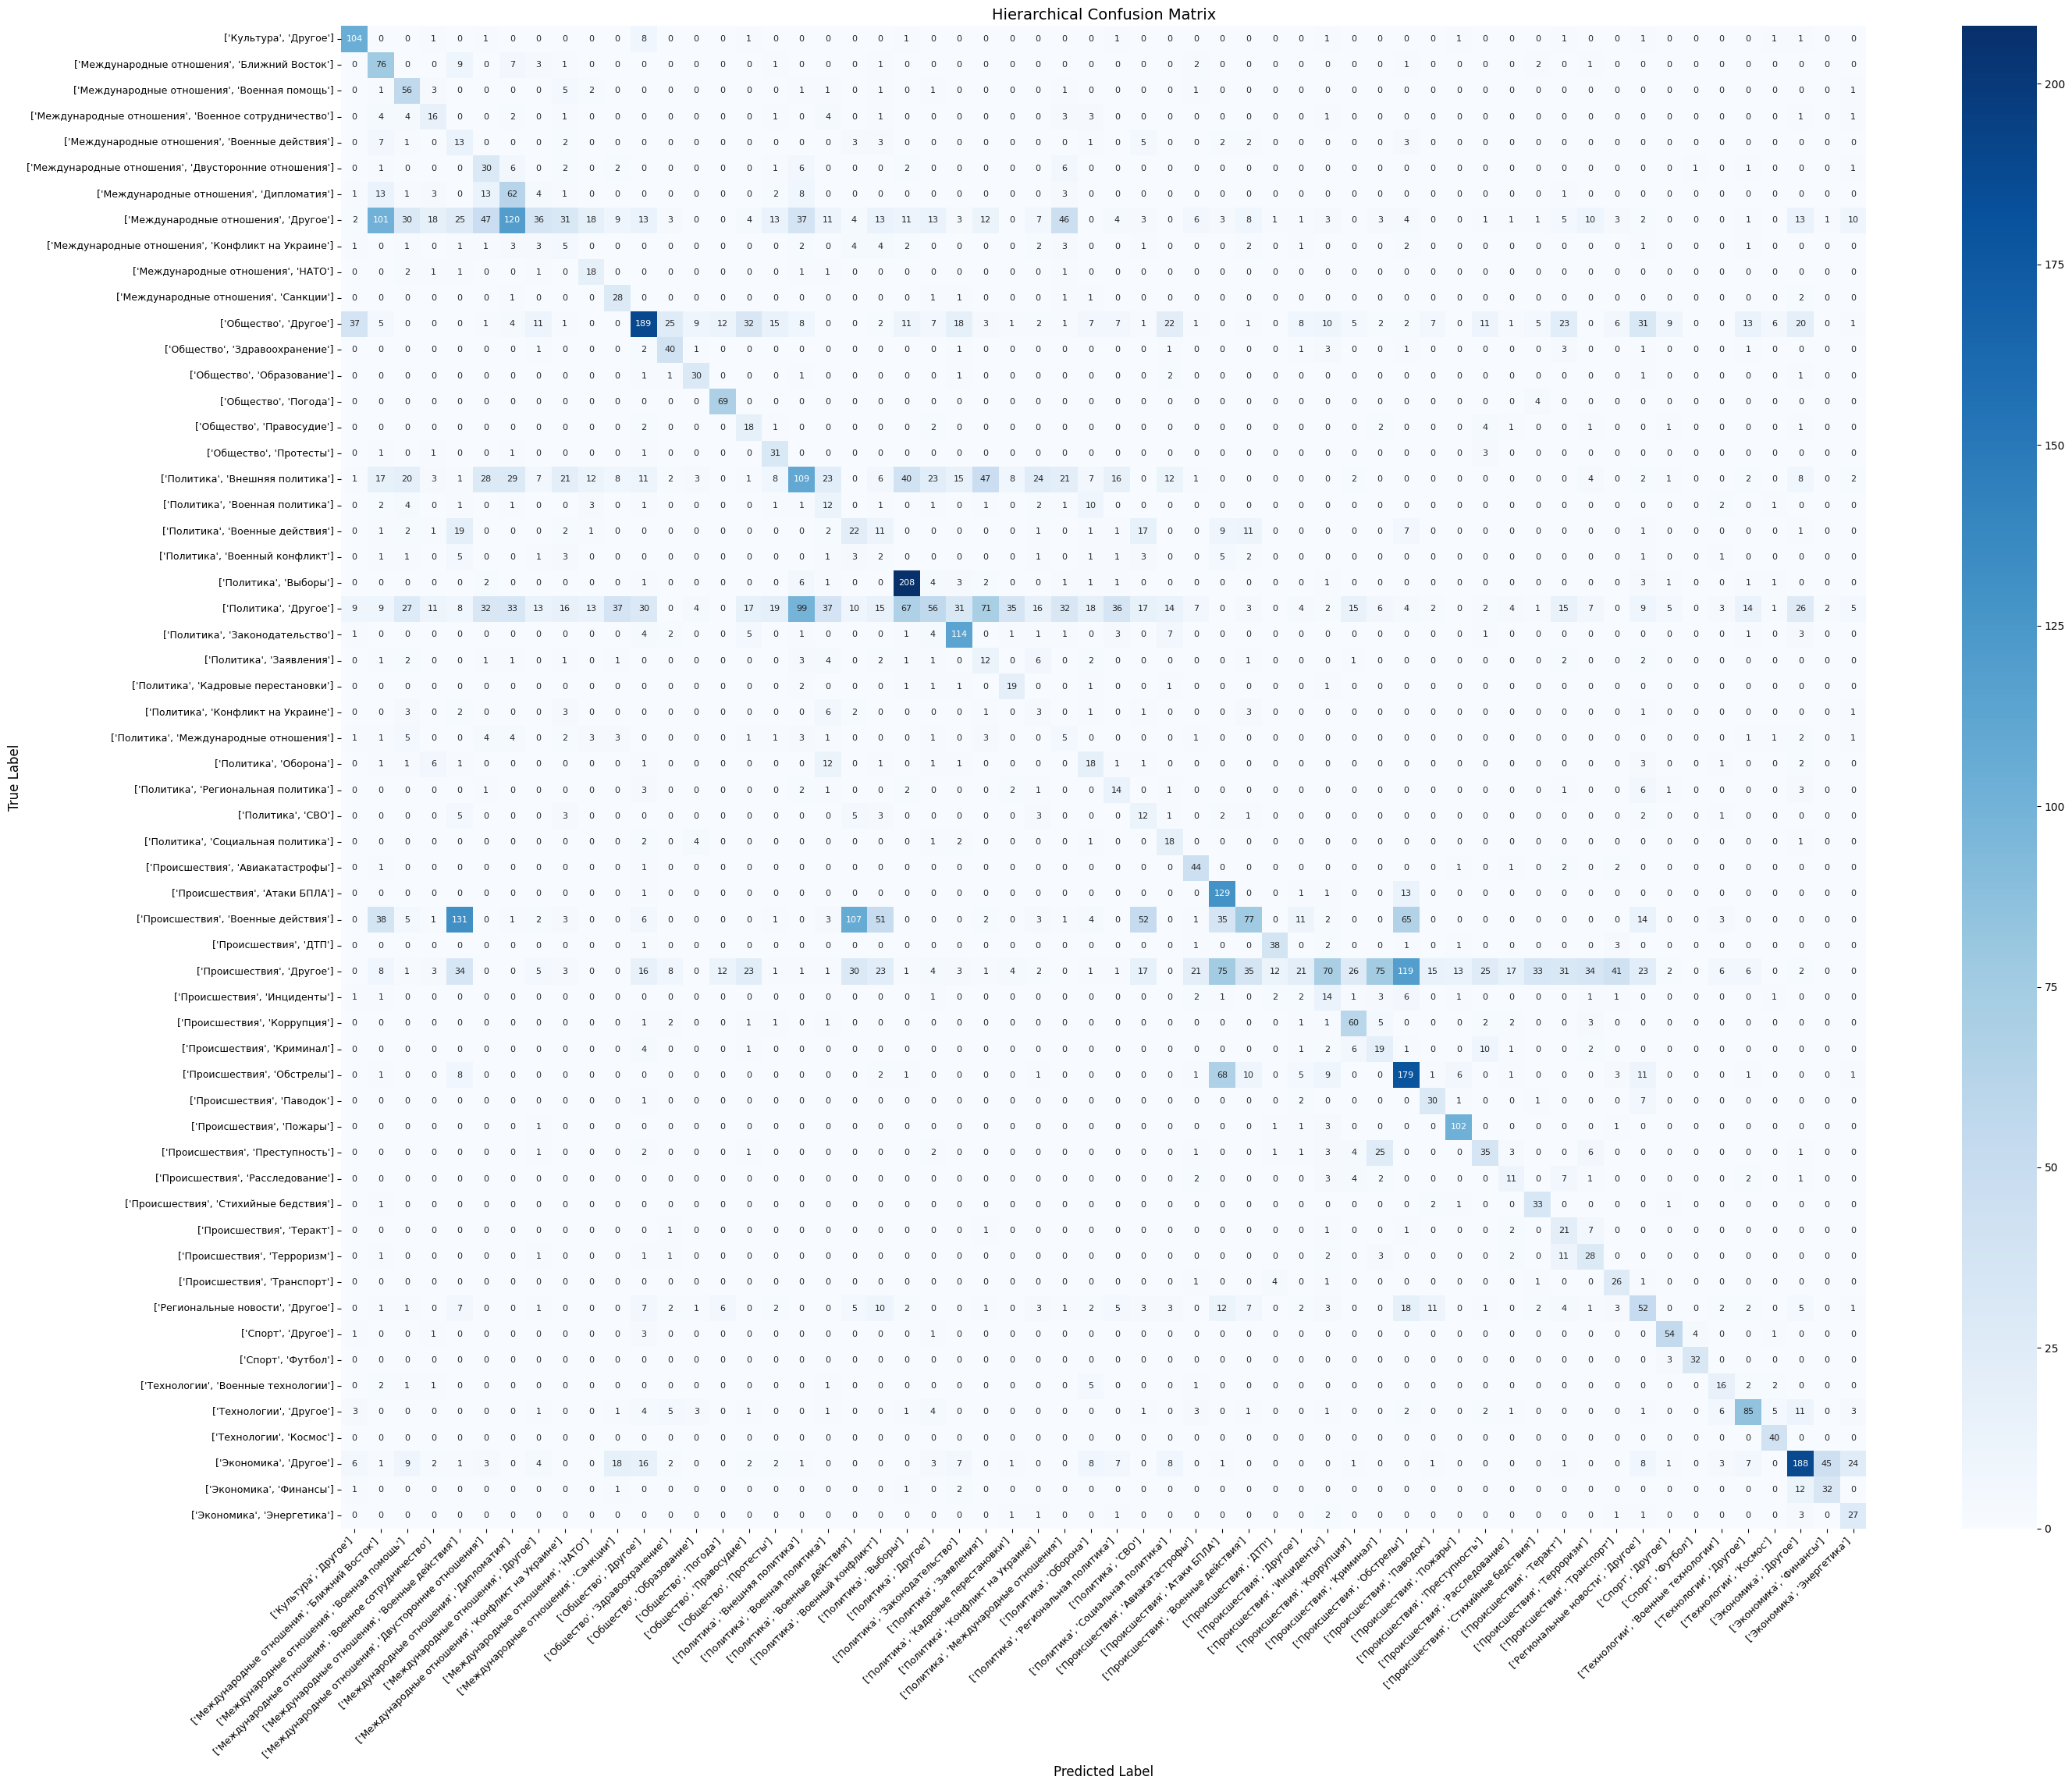

In [22]:
evaluate_model(trained_model, val_dataloader, device, mlb, idx_to_hier_map_final)